In [1]:
!pip install pennylane scikit-learn matplotlib

import pennylane as qml
from pennylane import numpy as npq
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay


In [6]:
data = load_breast_cancer()
X = data.data
y = data.target

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pad to fit number of qubits (e.g., 4 qubits × 3 rotations = 12 features)
n_qubits = 4
features_per_qubit = 3
input_dim = n_qubits * features_per_qubit

if X_scaled.shape[1] < input_dim:
    padding = np.zeros((X_scaled.shape[0], input_dim - X_scaled.shape[1]))
    X_scaled = np.hstack((X_scaled, padding))
else:
    X_scaled = X_scaled[:, :input_dim]

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [7]:
n_layers = 2
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface="autograd")
def quantum_model(x, weights):
    # Dense encoding: 3 rotations per qubit
    for i in range(n_qubits):
        qml.RX(x[i * 3], wires=i)
        qml.RY(x[i * 3 + 1], wires=i)
        qml.RZ(x[i * 3 + 2], wires=i)

    # Learnable entangling layer
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    
    return qml.expval(qml.PauliZ(0))


In [8]:
def compute_loss(weights, X, y):
    preds = npq.array([quantum_model(x, weights) for x in X])
    preds = (preds + 1) / 2  # map from [-1,1] to [0,1]
    return npq.mean((preds - y) ** 2)

from pennylane.optimize import NesterovMomentumOptimizer
weights = npq.array(0.01 * np.random.randn(n_layers, n_qubits, 3), requires_grad=True)
opt = NesterovMomentumOptimizer(stepsize=0.5)

epochs = 20
losses = []

for epoch in range(epochs):
    weights, loss = opt.step_and_cost(lambda w: compute_loss(w, X_train, y_train), weights)
    losses.append(loss)
    print(f"Epoch {epoch+1:02d} | Loss: {loss:.4f}")


Epoch 01 | Loss: 0.2375
Epoch 02 | Loss: 0.2368
Epoch 03 | Loss: 0.2358
Epoch 04 | Loss: 0.2346
Epoch 05 | Loss: 0.2334
Epoch 06 | Loss: 0.2321
Epoch 07 | Loss: 0.2309
Epoch 08 | Loss: 0.2297
Epoch 09 | Loss: 0.2286
Epoch 10 | Loss: 0.2275
Epoch 11 | Loss: 0.2266
Epoch 12 | Loss: 0.2256
Epoch 13 | Loss: 0.2247
Epoch 14 | Loss: 0.2238
Epoch 15 | Loss: 0.2229
Epoch 16 | Loss: 0.2219
Epoch 17 | Loss: 0.2210
Epoch 18 | Loss: 0.2200
Epoch 19 | Loss: 0.2190
Epoch 20 | Loss: 0.2180


In [9]:
def predict(X, weights, threshold=0.5):
    preds = np.array([quantum_model(x, weights) for x in X])
    probs = (preds + 1) / 2
    return (probs > threshold).astype(int)

y_pred = predict(X_test, weights)
acc = accuracy_score(y_test, y_pred)
print(f"\nTest Accuracy: {acc:.4f}")


Test Accuracy: 0.6930


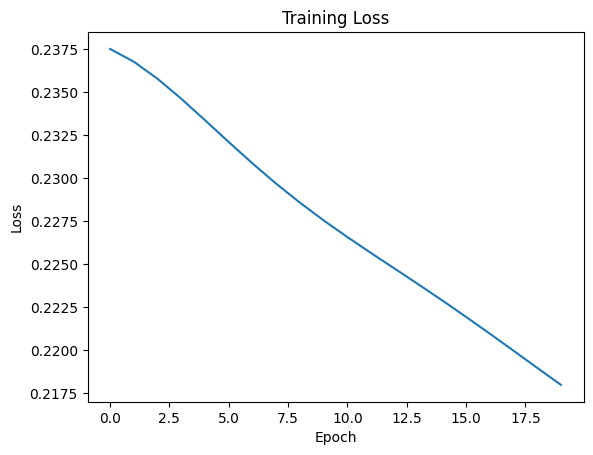

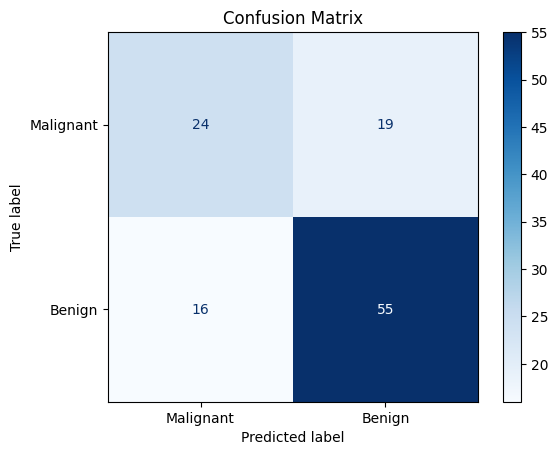

In [10]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["Malignant", "Benign"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()
